In [8]:
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os,glob,shutil
from torchvision.ops import nms  # For non-maximum suppression

In [23]:
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.build_sam import build_sam2_video_predictor
from PIL import Image, ImageOps

In [2]:
# Initializing the SAM2 model and related components
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

C:\Users\Varun Sayam\Anaconda\envs\samm\segment-anything-2\sam2\modeling\sam\transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [24]:
checkpoint = "../checkpoints/sam2_hiera_tiny.pt"
model_cfg = "sam2_hiera_t.yaml"
predictor_prompt = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint))
sam2 = build_sam2(model_cfg, checkpoint, device='cuda', apply_postprocessing=False)
mask_generator = SAM2AutomaticMaskGenerator(sam2)
predictor_vid = build_sam2_video_predictor(model_cfg, checkpoint, device='cuda')
tempfolder = "./tempdir"

In [27]:
def create_if_not_exists(dirname):
    if not os.path.exists(dirname):
       os.mkdir(dirname)

In [28]:
def cleardir(tempfolder):
      filepaths = glob.glob(tempfolder+"/*")
      for filepath in filepaths:
          os.unlink(filepath)

In [29]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
      color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
      cmap = plt.get_cmap("tab10")
      cmap_idx = 0 if obj_id is None else obj_id
      color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [30]:
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

In [31]:
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [4]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    """Display the mask on the plot."""
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [205]:
def process_img_png_mask(img_path, mask_path, visualize=False):
    """
    Processing an image and its corresponding mask to calculate the bounding box.
    
    Args:
    - img_path (str): Path to the image file.
    - mask_path (str): Path to the mask file.
    - visualize (bool): If True, visualizes the image and bounding box.
    
    Returns:
    - bbox (list): List containing bounding box coordinates [xmin, xmax, ymin, ymax].
    """
    # Loading image and mask
    img = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")  # Convert mask to grayscale
    
    # Converting mask to numpy array
    mask_array = np.array(mask)
    
    # Finding coordinates of the bounding box from mask
    indices = np.argwhere(mask_array > 0)  # Get indices where mask is not zero
    if indices.size == 0:
        print("No valid mask found in the image.")
        return None

    ymin, xmin = indices.min(axis=0)
    ymax, xmax = indices.max(axis=0)
    bbox = [xmin, xmax, ymin, ymax]
    
    # Visualization
    if visualize:
        fig, ax = plt.subplots()
        ax.imshow(img)
        
        # Drawing bounding box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.title("Image with Bounding Box")
        plt.show()
    
    return bbox

In [231]:

def track_item_boxes(imgpath1,imgpath2,img1boxclasslist,visualize=True):
# imgpath1 :: Image where object is known
# imgpath2 :: Image where object is to be tracked
# img1boxclasslist :: [ ([xmin,xmax,ymin,ymax],objectnumint) ,....] for all objects in imagepath1
    create_if_not_exists(tempfolder)
    cleardir(tempfolder)
    shutil.copy(imgpath1,tempfolder+"/00000.jpg")
    shutil.copy(imgpath2,tempfolder+"/00001.jpg")
    inference_state = predictor_vid.init_state(video_path="./tempdir")
    predictor_vid.reset_state(inference_state)
    ann_frame_idx = 0
    
    for img1boxclass in img1boxclasslist:
        ([xmin,xmax,ymin,ymax],objectnumint) = img1boxclass
        box = np.array([xmin, ymin, xmax, ymax], dtype=np.float32)
        _, out_obj_ids, out_mask_logits = predictor_vid.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=ann_frame_idx,
        obj_id=objectnumint,
        box=box,
        )
        
    video_segments = {} # video_segments contains the per-frame segmentation results
    for out_frame_idx, out_obj_ids, out_mask_logits in predictor_vid.propagate_in_video(inference_state):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
            }

    out_frame_idx = 1  
    out_obj_id = 1  

    if out_frame_idx in video_segments and out_obj_id in video_segments[out_frame_idx]:
        relevant_mask = video_segments[out_frame_idx][out_obj_id]
        predicted_bbox = mask_to_bbox(relevant_mask)
        print(f"Predicted Bounding Box: {predicted_bbox}")
    else:
        print("Error: Specified frame index or object ID not found in video_segments.")

    
    if visualize:
        fig, ax = plt.subplots()
        plt.title(f"original image object ::")
        ax.imshow(Image.open(tempfolder+"/00000.jpg"))
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r')
        ax.add_patch(rect)
        plt.show()
        out_frame_idx = 1
        plt.figure(figsize=(6, 4))
        plt.title(f"detected object in test image ::")
        plt.imshow(Image.open(tempfolder+"/00001.jpg"))
        for out_obj_id, out_mask in video_segments[out_frame_idx].items():
            show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
    return video_segments


In [185]:
data_2d_folder_path = r"C:\Users\Varun Sayam\Downloads\CMU10_3D\data_2D"

## For Can_Chowder

In [186]:
firstimgpath = os.path.join(data_2d_folder_path,'can_chowder_000001.jpg')
firstimgmaskpath = os.path.join(data_2d_folder_path,'can_chowder_000001_1_gt.png')

In [187]:
secondimgpath = os.path.join(data_2d_folder_path,'can_chowder_000002.jpg')

In [203]:
# Calculating bounding box from mask
[xmin, xmax, ymin, ymax] = process_img_png_mask(firstimgpath, firstimgmaskpath, visualize=False)

propagate in video: 100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.72it/s]


Error: Mask is not 2D. Reshaping to 2D.
Coordinates of non-zero pixels (coords): [[150 283]
 [150 284]
 [150 285]
 ...
 [278 290]
 [278 291]
 [278 292]]
Shape of coords: (9014, 2)
Predicted Bounding Box: [249, 150, 331, 278]


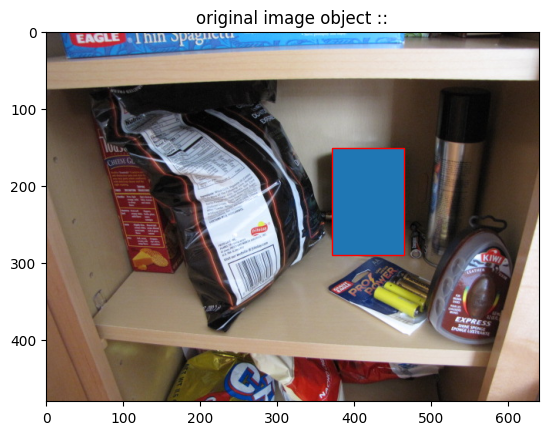

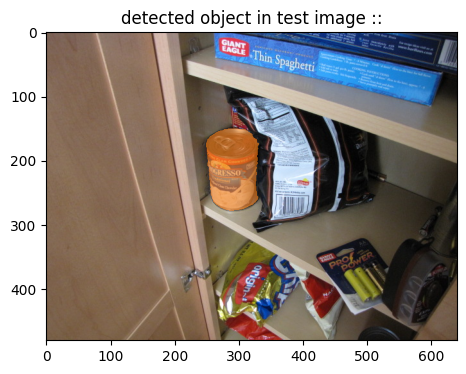

In [204]:
# Tracking items using bounding box
if [xmin, xmax, ymin, ymax]:
    result_masks = track_item_boxes(firstimgpath, secondimgpath, [([xmin, xmax, ymin, ymax], 1)], visualize=True)
else:
    print("Bounding box calculation failed.")

In [77]:
[xmin, xmax, ymin, ymax]

[371, 464, 150, 290]

In [194]:
result_masks

{0: {1: array([[[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]]])},
 1: {1: array([[[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]]])}}

## Mask to Box 

In [96]:
"""
def mask_to_bbox(mask):
    """
    Convert a binary mask to a bounding box [xmin, ymin, xmax, ymax].
    
    Args:
    - mask (numpy array): Binary mask of the object (2D array where 1 indicates object presence).
    
    Returns:
    - bbox (list): Bounding box in [xmin, ymin, xmax, ymax] format.
    """
    # Find coordinates where mask is non-zero (object pixels)
    coords = np.argwhere(mask)
    
    # If no coordinates found, return an empty box
    if coords.size == 0:
        return [0, 0, 0, 0]
    
    # Calculate min and max points
    ymin, xmin = coords.min(axis=0)
    ymax, xmax = coords.max(axis=0)
    
    return [xmin, ymin, xmax, ymax]
"""

In [192]:
def mask_to_bbox(mask):
    """
    Convert a binary mask to a bounding box [xmin, ymin, xmax, ymax].
    
    Args:
    - mask (numpy array): Binary mask of the object (2D array where 1 indicates object presence).
    
    Returns:
    - bbox (list): Bounding box in [xmin, ymin, xmax, ymax] format.
    """
    # Ensure the mask is a binary mask and is 2D
    if mask.ndim != 2:
        print("Error: Mask is not 2D. Reshaping to 2D.")
        mask = mask.squeeze()  # Remove singleton dimensions if any

    mask = (mask > 0).astype(np.uint8)
    
    # Find coordinates where mask is non-zero (object pixels)
    coords = np.argwhere(mask)
    
    # Debugging: Print the shape and contents of coords
    print("Coordinates of non-zero pixels (coords):", coords)
    print("Shape of coords:", coords.shape)

    # If no coordinates found, return an empty box
    if coords.size == 0:
        print("Warning: Empty mask detected. Returning default bounding box [0, 0, 0, 0].")
        return [0, 0, 0, 0]
    
    # Calculate min and max points correctly
    ymin, xmin = coords.min(axis=0)  # Minimum y and x coordinates
    ymax, xmax = coords.max(axis=0)  # Maximum y and x coordinates
    
    return [xmin, ymin, xmax, ymax]


In [174]:
print(np.unique(relevant_mask))  

[{1: array([[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]])} ]


In [197]:
predicted_bbox = [249, 150, 331, 278]

In [198]:
predicted_bbox

[249, 150, 331, 278]

In [199]:
print(f"Predicted Bounding Box: {predicted_bbox}")

Predicted Bounding Box: [249, 150, 331, 278]


## Pycocotols 

In [105]:
pip install pycocotools

Note: you may need to restart the kernel to use updated packages.


In [169]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval


def calculate_detection_performance(predicted_bboxes, gt_bboxes):
    """
    Calculate the object detection performance using pycocotools.
    
    Args:
    - predicted_bboxes (list of lists): List of predicted bounding boxes in [xmin, ymin, xmax, ymax] format.
    - gt_bboxes (list of lists): List of ground truth bounding boxes in [xmin, ymin, xmax, ymax] format.
    
    Returns:
    - metrics (dict): Performance metrics (IoU, Precision, Recall, etc.).
    """
    # Convert bounding boxes to COCO format
    coco_gt_data = convert_to_coco_format(gt_bboxes, image_id=1, category_id=1)
    coco_pred_data = convert_to_coco_format(predicted_bboxes, image_id=1, category_id=1, is_prediction=True)
    
    # Create COCO objects for ground truth
    coco_gt = COCO()  # Initialize empty COCO object
    coco_gt.dataset = coco_gt_data  # Assign ground truth data to COCO object
    coco_gt.createIndex()  # Index the annotations for COCO
    
    # Load predictions into COCO format
    coco_dt = coco_gt.loadRes(coco_pred_data['annotations'])

    # Evaluate using COCOeval
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    
    # Extract relevant metrics (Example: Mean Average Precision at IoU 0.50)
    mAP = coco_eval.stats[0]  # mAP@IoU=0.50
    
    return {"mAP@0.50": mAP}

In [166]:

def convert_to_coco_format(bboxes, image_id=1, category_id=1, is_prediction=False):
    """
    Convert bounding boxes to COCO-style dictionary format.
    
    Args:
    - bboxes (list of lists): List of bounding boxes in [xmin, ymin, xmax, ymax] format.
    - image_id (int): Image ID in COCO format.
    - category_id (int): Category ID in COCO format.
    - is_prediction (bool): If True, add a 'score' field for predictions.
    
    Returns:
    - coco_format (dict): COCO-style annotations and image information.
    """
    if not isinstance(bboxes, list) or not all(isinstance(bbox, list) and len(bbox) == 4 for bbox in bboxes):
        raise ValueError("bboxes must be a list of lists, where each list contains 4 integers [xmin, ymin, xmax, ymax].")

    annotations = []
    for i, bbox in enumerate(bboxes):
        # Convert [xmin, ymin, xmax, ymax] to [x, y, width, height]
        x, y = bbox[0], bbox[1]
        width, height = bbox[2] - bbox[0], bbox[3] - bbox[1]
        area = width * height
        
        annotation = {
            "id": i + 1,
            "image_id": image_id,
            "category_id": category_id,
            "bbox": [x, y, width, height],
            "area": area,
            "iscrowd": 0
        }
        
        # If it's a prediction, add a 'score' field
        if is_prediction:
            annotation["score"] = 1.0  # Example confidence score; adjust as needed
        
        # Add to annotations
        annotations.append(annotation)

    # COCO format dictionary
    coco_format = {
        "images": [{"id": image_id, "width": 640, "height": 480}],  # Example image size; adjust as needed
        "annotations": annotations,
        "categories": [{"id": category_id, "name": "object"}]
    }
    
    return coco_format


In [138]:
gt_bbox = mask_to_bbox(np.array(Image.open(r'C:\Users\Varun Sayam\Downloads\CMU10_3D\data_2D\can_chowder_000002_1_gt.png')))

In [139]:
[gt_bbox]

[[249, 148, 336, 278]]

In [167]:
# Converting predicted and ground truth bounding boxes to COCO format
coco_pred_data = convert_to_coco_format([predicted_bbox], image_id=1, category_id=1)
coco_gt_data = convert_to_coco_format([gt_bbox], image_id=1, category_id=1)

In [200]:
performance_metrics = calculate_detection_performance([predicted_bbox], [gt_bbox])

creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.900
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.900
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.900
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.900
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.900
 Average Recall     (AR) @[ IoU=0

In [201]:
print(performance_metrics)

{'mAP@0.50': 0.8999999999999999}


## For Can_Soymilk

In [264]:
firstimgpathsoymilk = os.path.join(data_2d_folder_path,'can_soymilk_000003.jpg')
firstimgmaskpathsoymilk = os.path.join(data_2d_folder_path,'can_soymilk_000003_1_gt.png')

In [265]:
secondimgpathsoymilk = os.path.join(data_2d_folder_path,'can_soymilk_000002.jpg')

In [266]:
soymilkboxclasslist = process_img_png_mask(firstimgpathsoymilk, firstimgmaskpathsoymilk, visualize=False)

propagate in video: 100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


Error: Mask is not 2D. Reshaping to 2D.
Coordinates of non-zero pixels (coords): []
Shape of coords: (0, 2)
Predicted Bounding Box: [0, 0, 0, 0]


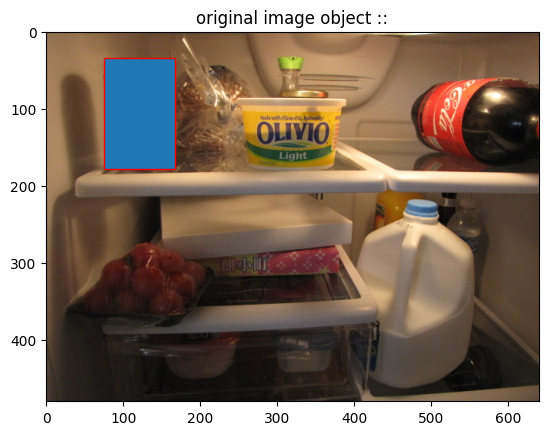

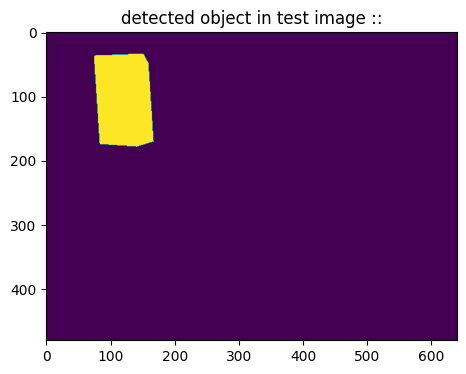

In [267]:
# Tracking items using bounding box
if [xmin, xmax, ymin, ymax]:
    result_masks_soymilk = track_item_boxes(firstimgpathsoymilk, firstimgmaskpathsoymilk, [(soymilkboxclasslist, 1)], visualize=True)
else:
    print("Bounding box calculation failed.")

In [233]:
predicted_bbox_soymilk = [0, 0, 0, 0]

In [235]:
gt_bbox_soymilk = mask_to_bbox(np.array(Image.open(r'C:\Users\Varun Sayam\Downloads\CMU10_3D\data_2D\can_soymilk_000002_1_gt.png')))

Coordinates of non-zero pixels (coords): [[174 462]
 [174 463]
 [174 464]
 ...
 [307 485]
 [307 486]
 [307 487]]
Shape of coords: (9013, 2)


In [242]:
[gt_bbox_soymilk]

[[426, 174, 517, 307]]

In [240]:
# Converting predicted and ground truth bounding boxes to COCO format
coco_pred_data = convert_to_coco_format([predicted_bbox_soymilk], image_id=1, category_id=1)
coco_gt_data = convert_to_coco_format([gt_bbox_soymilk], image_id=1, category_id=1)

In [241]:
performance_metrics = calculate_detection_performance([predicted_bbox_soymilk], [gt_bbox_soymilk])

creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0

In [243]:
print(performance_metrics)

{'mAP@0.50': 0.0}


## For Tomato soup

In [255]:
firstimgpathtomatos = os.path.join(data_2d_folder_path,'can_tomatosoup_000001.jpg')
firstimgmaskpathtomatos = os.path.join(data_2d_folder_path,'can_tomatosoup_000001_1_gt.png')

In [256]:
secondimgpathtomatos = os.path.join(data_2d_folder_path,'can_tomatosoup_000002.jpg')

In [257]:
tomatosboxclasslist = process_img_png_mask(firstimgpathtomatos, firstimgmaskpathtomatos, visualize=False)

propagate in video: 100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.75it/s]


Error: Mask is not 2D. Reshaping to 2D.
Coordinates of non-zero pixels (coords): []
Shape of coords: (0, 2)
Predicted Bounding Box: [0, 0, 0, 0]


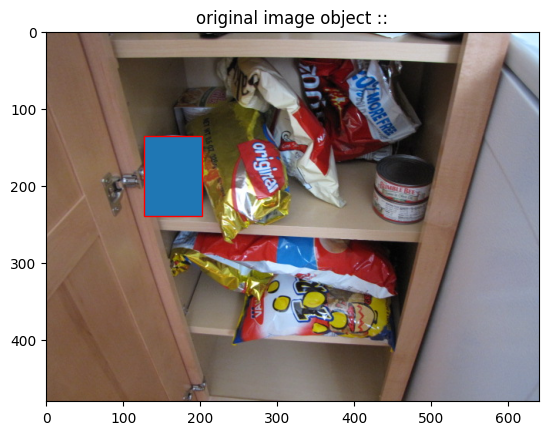

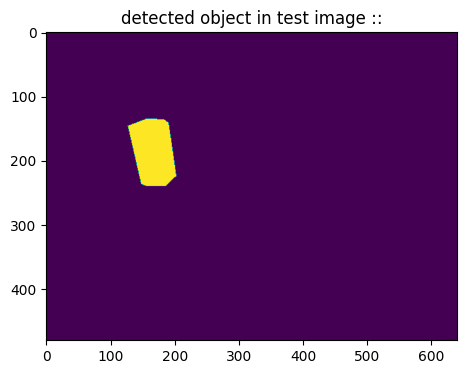

In [258]:
# Tracking items using bounding box
if [xmin, xmax, ymin, ymax]:
    result_masks = track_item_boxes(firstimgpathtomatos, firstimgmaskpathtomatos, [(tomatosboxclasslist, 1)], visualize=True)
else:
    print("Bounding box calculation failed.")

In [259]:
predicted_bbox_tomatos = [0, 0, 0, 0]

In [260]:
gt_bbox_tomatos = mask_to_bbox(np.array(Image.open(r'C:\Users\Varun Sayam\Downloads\CMU10_3D\data_2D\can_tomatosoup_000002_1_gt.png')))

Coordinates of non-zero pixels (coords): [[133 171]
 [133 172]
 [133 173]
 ...
 [221 230]
 [221 231]
 [221 232]]
Shape of coords: (5032, 2)


In [261]:
# Converting predicted and ground truth bounding boxes to COCO format
coco_pred_data = convert_to_coco_format([predicted_bbox_tomatos], image_id=1, category_id=1)
coco_gt_data = convert_to_coco_format([gt_bbox_tomatos], image_id=1, category_id=1)

In [262]:
performance_metrics = calculate_detection_performance([predicted_bbox_tomatos], [gt_bbox_tomatos])

creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0

In [263]:
print(performance_metrics)

{'mAP@0.50': 0.0}
